In [47]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
# import statfieldodels.api as sm
import xarray as xr

from salishsea_tools import viz_tools
import netCDF4 as nc
import arrow
import copy
import math
import matplotlib.dates as mdates


In [48]:
mycmap = copy.copy(cm.oxy)
mycmap.set_bad('darkgreen')

In [49]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc') as mesh:
    tmask = mesh.tmask
    mbathy = mesh.mbathy

In [50]:
# Constant and data rang
syear = 2007
eyear = 2007
smonth = 1
emonth = 12
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 31)
print (startdate, enddate)

2007-01-01T00:00:00+00:00 2007-12-31T00:00:00+00:00


In [51]:
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1d_20230401_20230401_chem_T.nc') as data_chem:
    oxy = data_chem['dissolved_oxygen']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1d_20230401_20230401_biol_T.nc') as data_biol:
    no3 = data_biol['nitrate']
    don = data_biol['dissolved_organic_nitrogen']
    pon = data_biol['particulate_organic_nitrogen']
    dia = data_biol['diatoms']
    fla = data_biol['flagellates']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1d_20230401_20230401_grid_T.nc') as data_grid:
    temp = data_grid['votemper']
    salt = data_grid['vosaline']
#    dens = data_grid['sigma_theta'] # almost same as salinity

In [52]:
tmask2_oxy = tmask.assign_coords(z=("z", oxy.deptht.data))
tmask2_oxy = tmask2_oxy.rename({"z": "deptht"})
tmask2_no3 = tmask.assign_coords(z=("z", no3.deptht.data))
tmask2_no3 = tmask2_no3.rename({"z": "deptht"})
tmask2_don = tmask.assign_coords(z=("z", don.deptht.data))
tmask2_don = tmask2_don.rename({"z": "deptht"})
tmask2_pon = tmask.assign_coords(z=("z", pon.deptht.data))
tmask2_pon = tmask2_pon.rename({"z": "deptht"})
tmask2_dia = tmask.assign_coords(z=("z", dia.deptht.data))
tmask2_dia = tmask2_dia.rename({"z": "deptht"})
tmask2_fla = tmask.assign_coords(z=("z", fla.deptht.data))
tmask2_fla = tmask2_fla.rename({"z": "deptht"})
tmask2_temp = tmask.assign_coords(z=("z", temp.deptht.data))
tmask2_temp = tmask2_temp.rename({"z": "deptht"})
tmask2_salt = tmask.assign_coords(z=("z", salt.deptht.data))
tmask2_salt = tmask2_salt.rename({"z": "deptht"})
#tmask2_dens = tmask.assign_coords(z=("z", dens.deptht.data))
#tmask2_dens = tmask2_dens.rename({"z": "deptht"})


In [53]:
print (oxy.deptht)

<xarray.DataArray 'deptht' (deptht: 40)>
array([  0.5     ,   1.500003,   2.500011,   3.500031,   4.500071,   5.500151,
         6.50031 ,   7.500623,   8.501236,   9.502433,  10.504766,  11.509312,
        12.518167,  13.535412,  14.568982,  15.634288,  16.761173,  18.007135,
        19.481785,  21.389978,  24.100256,  28.229916,  34.685757,  44.517723,
        58.484333,  76.58559 ,  98.06296 , 121.866516, 147.08946 , 173.11449 ,
       199.57304 , 226.2603  , 253.06664 , 279.93454 , 306.8342  , 333.75018 ,
       360.67453 , 387.6032  , 414.5341  , 441.4661  ], dtype=float32)
Coordinates:
  * deptht   (deptht) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
Attributes:
    standard_name:  sea_floor_depth
    long_name:      Sea Floor Depth
    units:          metres
    positive:       down


In [54]:
first = True
i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
#i1, i2, j1, j2 = (95, 170, 76, 120)  # Central Hood Canal
#i1, i2, j1, j2 = (106, 119, 69, 79)  # 
#i1lc, i2lc, j1lc, j2lc = (120, 150, 68, 75)  # Lynch Cove
i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47°25'18.5"N 123°06'45.3"W
i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.37°N, 123.01°W
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_chem = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
    with xr.open_dataset(filename_chem) as ds_chem:
        oxyhs = ds_chem['dissolved_oxygen'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_oxy[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        oxylc = ds_chem['dissolved_oxygen'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_oxy[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        if first:
            first = False
            oxyhs_ts = oxyhs
            oxylc_ts = oxylc
        else:
            oxyhs_ts = xr.concat([oxyhs_ts, oxyhs], dim='time_counter')
            oxylc_ts = xr.concat([oxylc_ts, oxylc], dim='time_counter')

In [55]:
oxylc_ts.shape

(365, 40)

In [56]:
first = True
i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
#i1, i2, j1, j2 = (95, 170, 76, 120)  # Central Hood Canal
#i1, i2, j1, j2 = (106, 119, 69, 79)  # 
#i1lc, i2lc, j1lc, j2lc = (120, 150, 68, 75)  # Lynch Cove
i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47°25'18.5"N 123°06'45.3"W
i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.37°N, 123.01°W
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_biol = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc'
    with xr.open_dataset(filename_biol) as ds_biol:
        no3hs = ds_biol['nitrate'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_no3[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        no3lc = ds_biol['nitrate'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_no3[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        donlc = ds_biol['dissolved_organic_nitrogen'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_don[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        donhs = ds_biol['dissolved_organic_nitrogen'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_don[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        ponlc = ds_biol['particulate_organic_nitrogen'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_pon[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        ponhs = ds_biol['particulate_organic_nitrogen'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_pon[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        dialc = ds_biol['diatoms'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_dia[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        diahs = ds_biol['diatoms'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_dia[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        flalc = ds_biol['flagellates'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_fla[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        flahs = ds_biol['flagellates'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_fla[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        if first:
            first = False
            no3hs_ts = no3hs
            no3lc_ts = no3lc
            donlc_ts = donlc
            donhs_ts = donhs
            ponlc_ts = ponlc
            ponhs_ts = ponhs
            dialc_ts = dialc
            diahs_ts = diahs
            flalc_ts = flalc
            flahs_ts = flahs
        else:
            no3hs_ts = xr.concat([no3hs_ts, no3hs], dim='time_counter')
            no3lc_ts = xr.concat([no3lc_ts, no3lc], dim='time_counter')
            donlc_ts = xr.concat([donlc_ts, donlc], dim='time_counter')
            donhs_ts = xr.concat([donhs_ts, donhs], dim='time_counter')
            ponlc_ts = xr.concat([ponlc_ts, ponlc], dim='time_counter')
            ponhs_ts = xr.concat([ponhs_ts, ponhs], dim='time_counter')
            dialc_ts = xr.concat([dialc_ts, dialc], dim='time_counter')
            diahs_ts = xr.concat([diahs_ts, diahs], dim='time_counter')
            flalc_ts = xr.concat([flalc_ts, flalc], dim='time_counter')
            diahs_ts = xr.concat([diahs_ts, diahs], dim='time_counter')

In [57]:
chllc_ts = (dialc_ts + flalc_ts) * 2
chlhs_ts = (diahs_ts + flahs_ts) * 2

In [58]:
first = True
i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
#i1, i2, j1, j2 = (95, 170, 76, 120)  # Central Hood Canal
#i1, i2, j1, j2 = (106, 119, 69, 79)  # 
#i1lc, i2lc, j1lc, j2lc = (120, 150, 68, 75)  # Lynch Cove
i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47°25'18.5"N 123°06'45.3"W
i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.37°N, 123.01°W
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_grid = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
    with xr.open_dataset(filename_grid) as ds_grid:
        temphs = ds_grid['votemper'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_temp[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        templc = ds_grid['votemper'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_temp[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        salths = ds_grid['vosaline'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_salt[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        saltlc = ds_grid['vosaline'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_salt[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        #dens = ds_grid['sigma_theta'][0, :, j1:j2, i1:i2].where(tmask2_dens[0, :, j1:j2, i1:i2] == 1).mean(axis=1).mean(axis=1)
        #denslc = ds_grid['sigma_theta'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_dens[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)        
        if first:
            first = False
            temphs_ts = temphs
            templc_ts = templc
            salths_ts = salths
            saltlc_ts = saltlc
            #dens_ts = dens
            #denslc_ts = denslc
        else:
            temphs_ts = xr.concat([temphs_ts, temphs], dim='time_counter')
            templc_ts = xr.concat([templc_ts, templc], dim='time_counter')
            salths_ts = xr.concat([salths_ts, salths], dim='time_counter')
            saltlc_ts = xr.concat([saltlc_ts, saltlc], dim='time_counter')
            #dens_ts = xr.concat([dens_ts, dens], dim='time_counter')
            #denslc_ts = xr.concat([denslc_ts, denslc], dim='time_counter')

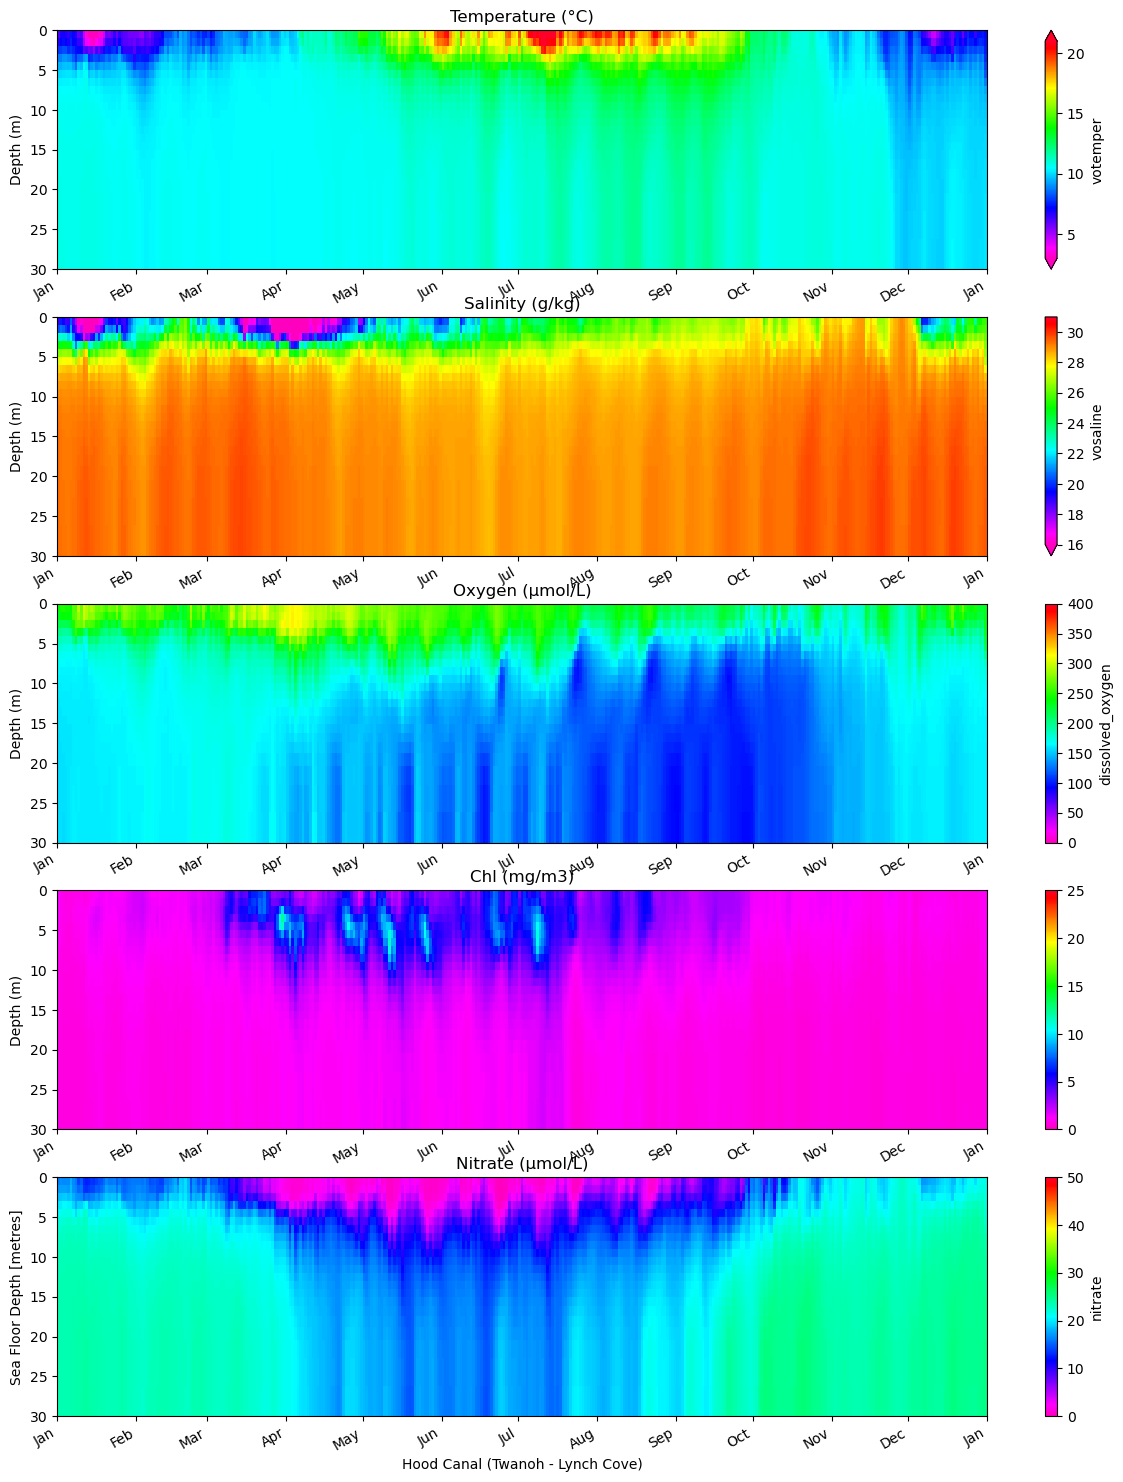

In [62]:
fig, ax = plt.subplots(5, 1, figsize=(15, 18))
templc_ts[:, :24].plot(ax=ax[0], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=3, vmax=21, ylim=(30, 0));
saltlc_ts[:, :24].plot(ax=ax[1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=16, vmax=31, ylim=(30, 0));
oxylc_ts[:, :24].plot(ax=ax[2], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=400, ylim=(30, 0));
chllc_ts[:, :24].plot(ax=ax[3], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(30, 0));
no3lc_ts[:, :24].plot(ax=ax[4], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=50, ylim=(30, 0));

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_ylabel('Depth (m)')
ax[3].set_ylabel('Depth (m)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')
ax[4].set_xlabel('Hood Canal (Twanoh - Lynch Cove)')

ax[0].set_title('Temperature (°C)')
ax[1].set_title('Salinity (g/kg)')
ax[2].set_title('Oxygen (µmol/L)')
ax[3].set_title('Chl (mg/m3)')
ax[4].set_title('Nitrate (µmol/L)')

# Make ticks on occurrences of each month:
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2].xaxis.set_major_locator(mdates.MonthLocator())
ax[3].xaxis.set_major_locator(mdates.MonthLocator())
ax[4].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

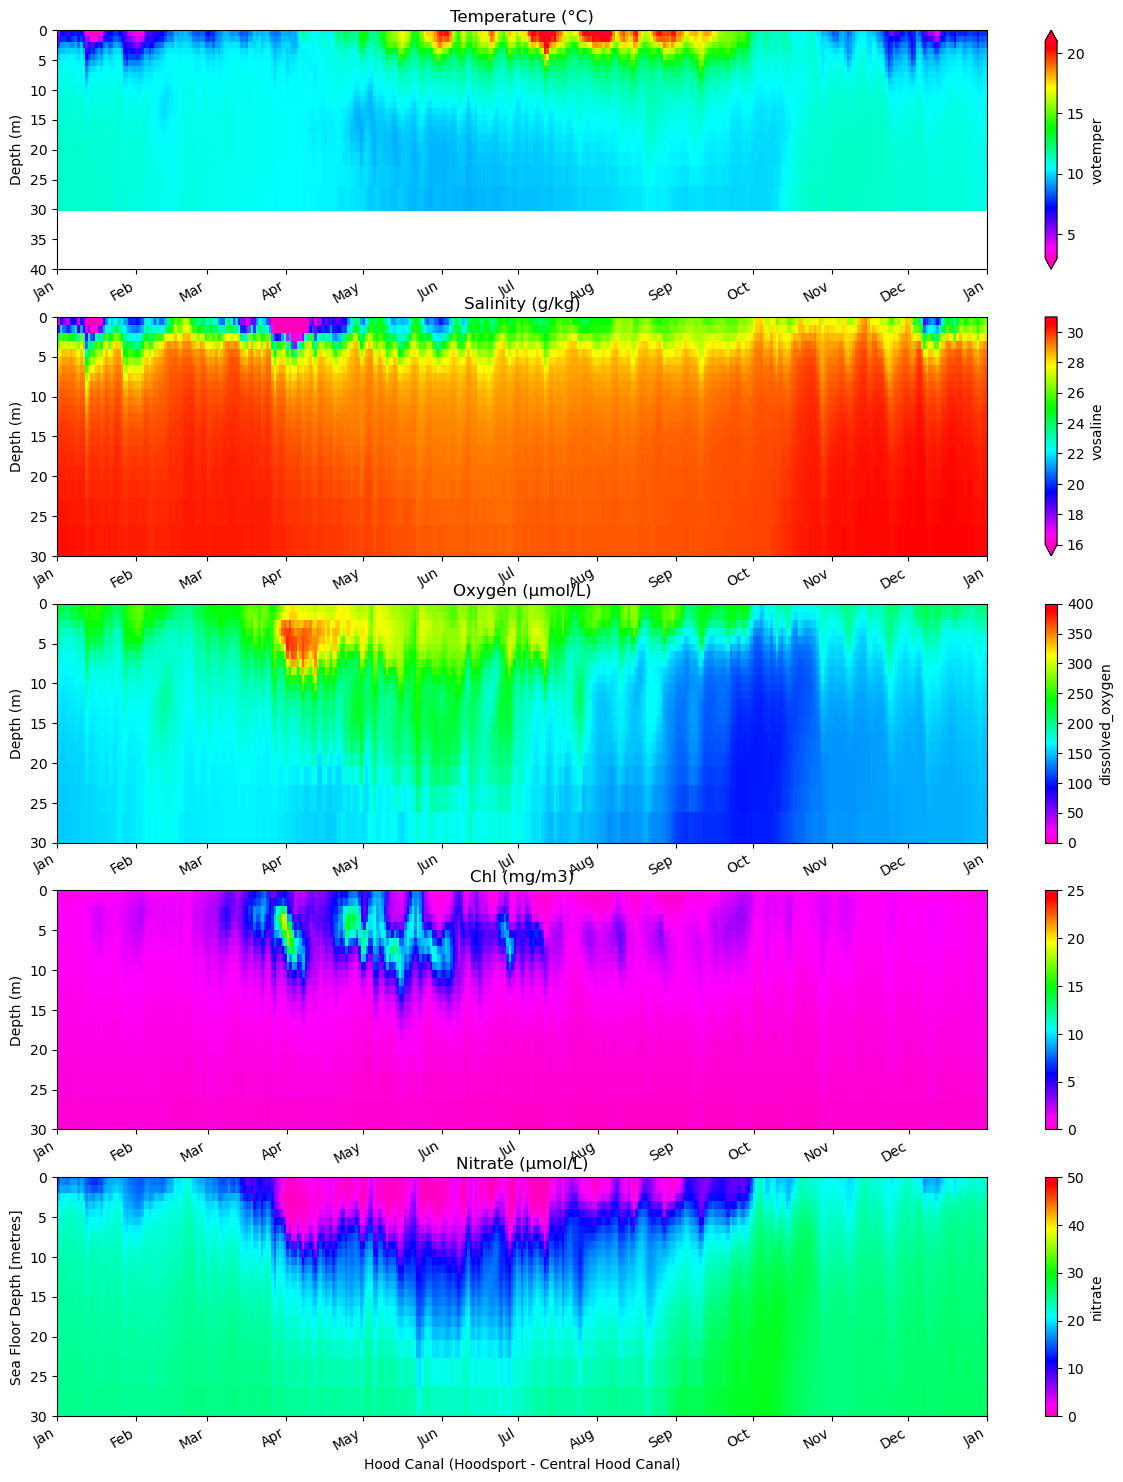

In [71]:
fig, ax = plt.subplots(5, 1, figsize=(15, 18))
temphs_ts[:, :24].plot(ax=ax[0], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=3, vmax=21, ylim=(30, 0));
salths_ts[:, :24].plot(ax=ax[1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=16, vmax=31, ylim=(30, 0));
oxyhs_ts[:, :24].plot(ax=ax[2], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=400, ylim=(30, 0));
chlhs_ts[:, :24].plot(ax=ax[3], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(30, 0));
no3hs_ts[:, :24].plot(ax=ax[4], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=50, ylim=(30, 0));

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_ylabel('Depth (m)')
ax[3].set_ylabel('Depth (m)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('')
ax[3].set_xlabel('')
ax[4].set_xlabel('Hood Canal (Hoodsport - Central Hood Canal)')

ax[0].set_title('Temperature (°C)')
ax[1].set_title('Salinity (g/kg)')
ax[2].set_title('Oxygen (µmol/L)')
ax[3].set_title('Chl (mg/m3)')
ax[4].set_title('Nitrate (µmol/L)')

# Make ticks on occurrences of each month:
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2].xaxis.set_major_locator(mdates.MonthLocator())
ax[3].xaxis.set_major_locator(mdates.MonthLocator())
ax[4].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

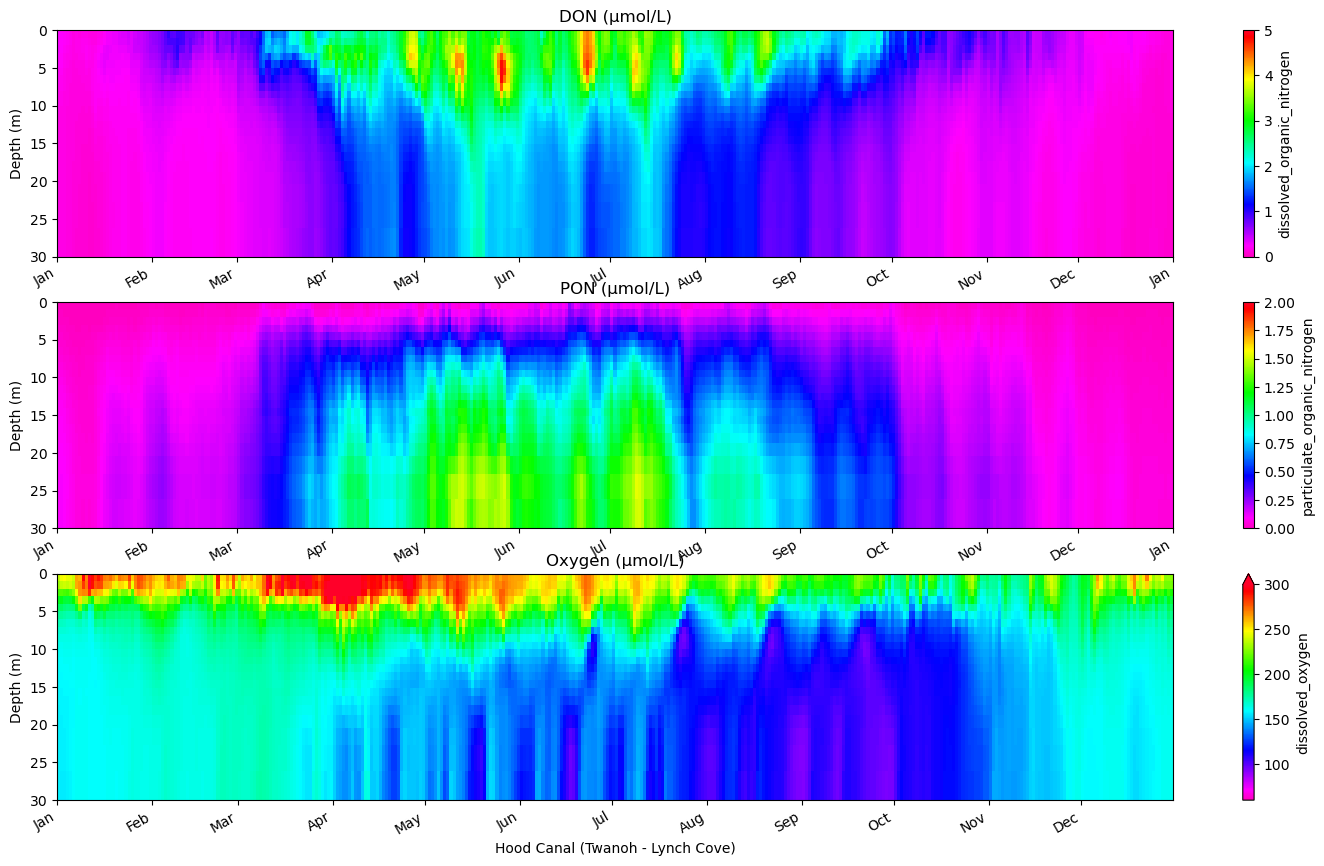

In [88]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10))
donlc_ts[:, :22].plot(ax=ax[0], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=0, vmax=5, ylim=(30, 0));
ponlc_ts[:, :22].plot(ax=ax[1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=2, ylim=(30, 0));
oxylc_ts[:, :22].plot(ax=ax[2], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=60, vmax=300, ylim=(30, 0));
ax[2].set_xlim(startdate, enddate)

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_ylabel('Depth (m)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('Hood Canal (Twanoh - Lynch Cove)')

ax[0].set_title('DON (µmol/L)')
ax[1].set_title('PON (µmol/L)')
ax[2].set_title('Oxygen (µmol/L)')

# Make ticks on occurrences of each month:
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))



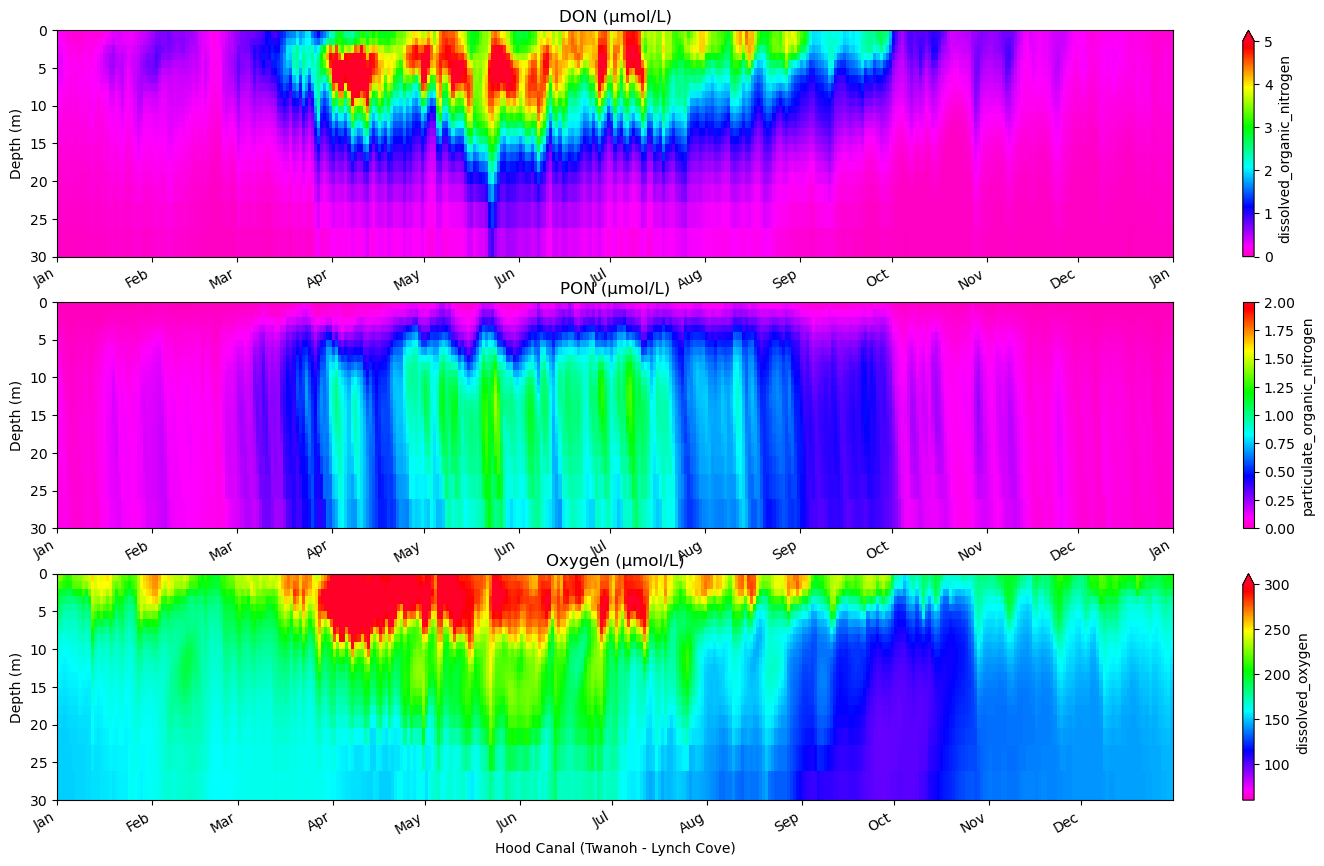

In [87]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10))
donhs_ts[:, :22].plot(ax=ax[0], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=0, vmax=5, ylim=(30, 0));
ponhs_ts[:, :22].plot(ax=ax[1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=2, ylim=(30, 0));
oxyhs_ts[:, :22].plot(ax=ax[2], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=60, vmax=300, ylim=(30, 0));
ax[2].set_xlim(startdate, enddate)

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_ylabel('Depth (m)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[2].set_xlabel('Hood Canal (Twanoh - Lynch Cove)')

ax[0].set_title('DON (µmol/L)')
ax[1].set_title('PON (µmol/L)')
ax[2].set_title('Oxygen (µmol/L)')

# Make ticks on occurrences of each month:
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

Text(10, 350, 'Lynch Cove (0-30 m, Apr-Sep)')

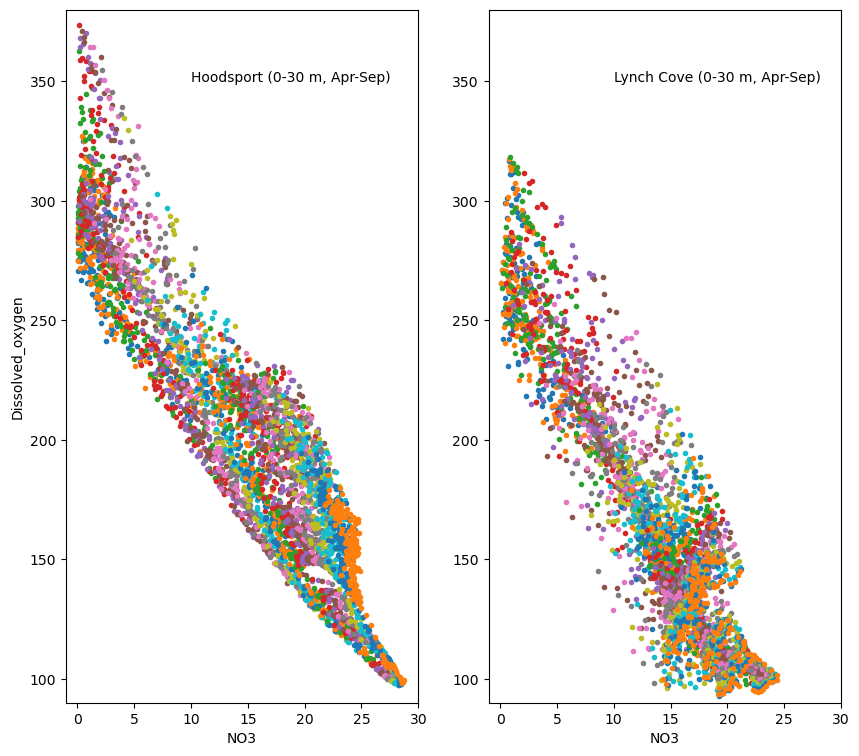

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(10, 9))
ax[0].plot(no3hs_ts[91:273, :22], oxyhs_ts[91:273, :22], '.');
ax[1].plot(no3lc_ts[91:273, :22], oxylc_ts[91:273, :22], '.');
ax[0].set_xlim(-1, 30)
ax[1].set_xlim(-1, 30)
ax[0].set_ylim(90, 380)
ax[1].set_ylim(90, 380)
ax[0].set_ylabel('Dissolved_oxygen')
ax[0].set_xlabel('NO3')
ax[1].set_xlabel('NO3')
ax[0].text(10, 350, 'Hoodsport (0-30 m, Apr-Sep)')
ax[1].text(10, 350, 'Lynch Cove (0-30 m, Apr-Sep)')
